In [2]:
import pandas as pd
import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline
# import _pickle as pk
from hmmlearn import hmm
import math
import os
from IPython.display import display
from pandas import ExcelWriter

# Load The Data

In [3]:
houses = {}
for i in range(1,7):
    house_name = 'house_{}'.format(i)
    data_name = 'house_{}.csv'.format(i)
    houses[house_name] = pd.read_csv(data_name)

# Convert raw time data to formatted time

In [4]:
for house_key in houses.keys():
    house = houses[house_key]
    house= house.drop('Unnamed: 0', axis = 1)
    house['time'] = pd.to_datetime(house['time'],format = '%Y-%m-%d %H:%M:%S')
    house['Weekday'] = house['time'].dt.weekday
    house['Hour'] = house['time'].dt.hour
    house['Minute'] = house['time'].dt.minute
    house['Seconds'] = house['time'].dt.second
    house['Month'] = house['time'].dt.month
    house['Day'] = house['time'].dt.day
    houses[house_key] = house

## Setting index to Datetime

In [5]:
# df_houses = {}
for house_key in houses.keys():
    house = houses[house_key]
    house['Datetime']= pd.to_datetime(house['time'], format = '%Y-%m-%d %H:%M:%S')
    house = house.set_index('Datetime')
    house = house.drop('time', axis=1)
    houses[house_key] = house  

## Load all the processed data with selected features

In [6]:
path = 'csv training data/csv training data/'
train_data_full = {}
names = list(houses['house_1'])[:-6]

sorted_names = sorted(names)

a,b = sorted_names.index('kitchen_outlets_x'), sorted_names.index('kitchen_outlets_x.1')
c,d = sorted_names.index('kitchen_outlets_y'), sorted_names.index('kitchen_outlets_y.1')
sorted_names[b], sorted_names[a] = sorted_names[a], sorted_names[b]
sorted_names[d], sorted_names[c] = sorted_names[c], sorted_names[d]


for (i,filename) in enumerate(os.listdir(path)):
    train_data_full[sorted_names[i]] = pd.read_csv(path + filename)

In [7]:
list(train_data_full)

['mains_x',
 'mains_y',
 'kitchen_outlets_x',
 'oven_y',
 'oven_x',
 'lighting_x',
 'stove',
 'lighting_y',
 'microwave',
 'kitchen_outlets_y.1',
 'washer_dryer_x',
 'washer_dryer_y',
 'kitchen_outlets_x.1',
 'electric_heat',
 'lighting',
 'dishwaser',
 'kitchen_outlets_y',
 'bathroom_gfi',
 'washer_dryer',
 'refrigerator']

## Preparing Data for HHM

In [8]:
class_full_data = pd.concat([train_data_full['refrigerator'],train_data_full['microwave'],train_data_full['oven_x'],train_data_full['washer_dryer']])
class_full_data_x = class_full_data
class_full_data_y = class_full_data
class_refrigerator_x = train_data_full['refrigerator']
class_microwave_x = train_data_full['microwave']
class_ovenx_x = train_data_full['oven_x']
class_washerdryer_x = train_data_full['washer_dryer']

In [9]:
class_refrigerator_x = train_data_full['refrigerator']
class_microwave_x = train_data_full['microwave']

class_lighting_x = train_data_full['lighting_x']
class_lighting_y = train_data_full['lighting_y']
class_kitchen_x1 = train_data_full['kitchen_outlets_x.1']
class_kitchen_y1 = train_data_full['kitchen_outlets_y.1']

refrigerator_train = class_refrigerator_x['Power'][:320000] - class_refrigerator_x['baseline_d'][:320000]
microwave_train = class_microwave_x['Power'][:320000] - class_microwave_x['baseline_d'][:320000]
lighting_x_train = class_lighting_x['Power'][:320000] - class_lighting_x['baseline_d'][:320000]

lighting_y_train = class_lighting_y['Power'][:320000] - class_lighting_y['baseline_d'][:320000]
kitchen_x1_train = class_kitchen_x1['Power'][:320000] - class_kitchen_x1['baseline_d'][:320000]
kitchen_y1_train = class_kitchen_y1['Power'][:320000] - class_kitchen_y1['baseline_d'][:320000]

lighting_y_test = class_lighting_y['Power'][320000:] - class_lighting_y['baseline_d'][320000:]
kitchen_x1_test = class_kitchen_x1['Power'][320000:] - class_kitchen_x1['baseline_d'][320000:]
kitchen_y1_test = class_kitchen_y1['Power'][320000:] - class_kitchen_y1['baseline_d'][320000:]

refrigerator_test = class_refrigerator_x['Power'][320000:] - class_refrigerator_x['baseline_d'][320000:]
washerdryer_test = class_washerdryer_x['Power'][320000:] - class_washerdryer_x['baseline_d'][320000:]

aggregate_data_train = refrigerator_train+microwave_train+lighting_y_train+kitchen_x1_train+kitchen_y1_train
aggregate_data_test = refrigerator_test+microwave_test+ovenx_test+washerdryer_test

## Refrigerator

In [12]:
X_train = np.column_stack([refrigerator_train])

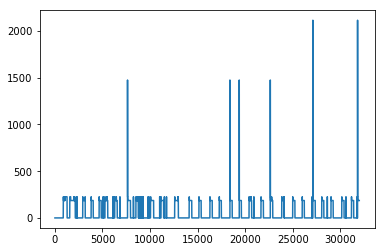

In [13]:
hmm_model = hmm.GMMHMM(n_components=5, covariance_type="full",n_iter = 1000,algorithm = 'viterbi')
hmm_model.fit(X_train)
hidden_states = hmm_model.predict(X_train)
means = hmm_model.means_.round().astype(int).flatten().tolist()
predict_levels = np.array([means[state] for state in hidden_states])
plt.plot(predict_levels[:50000])

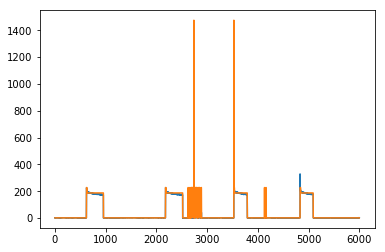

In [14]:
## Trying it on the aggregated test case

X_test = np.column_stack([aggregate_data_test])

hidden_states_test = hmm_model.predict(X_test)
means = hmm_model.means_.round().astype(int).flatten().tolist()
predict_levels = np.array([means[state] for state in hidden_states_test])

actual = np.array(refrigerator_test[:6000])

plt.plot(actual)
plt.plot(predict_levels[:6000])

## Now we will try to improve our model

In [39]:
hmm_model.transmat_

array([[  9.09515633e-001,   4.34027742e-002,   2.77230931e-003,
          4.43092832e-002,   9.46335645e-088],
       [  2.34316153e-003,   9.97185966e-001,   4.70826411e-004,
          4.60923024e-008,   1.18372191e-109],
       [  3.41240707e-003,   2.01766469e-002,   9.54750818e-001,
          1.69134909e-002,   4.74663746e-003],
       [  1.12496414e-003,   3.50531314e-003,   1.12671311e-003,
          9.94243010e-001,   1.98258010e-058],
       [  6.14095255e-096,   1.16785210e-106,   7.23715614e-002,
          2.18909514e-093,   9.27628439e-001]])

In [ ]:
# We will customize intial probability emission and transitiion matrix
model = hmm.GMHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],[0.3, 0.5, 0.2], [0.3, 0.3, 0.4]])
# model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
# model.covars_ = np.tile(np.identity(2), (3, 1, 1))

In [236]:
# train the models for refrigerator and microwave respectively
class_microwave_x = train_data_full['microwave']
microwave_train = class_microwave_x['Power'][:320000] - class_microwave_x['baseline_d'][:320000]
microwave_test = class_microwave_x['Power'][320000:] - class_microwave_x['baseline_d'][320000:]

X_train = np.column_stack([refrigerator_train])

ref_model = hmm.GMMHMM(n_components=3, covariance_type="full",n_iter = 1000,algorithm = 'viterbi')
ref_model.fit(X_train)

X_train = np.column_stack([microwave_train])

micro_model = hmm.GMMHMM(n_components=3, covariance_type="full",n_iter = 1000,algorithm = 'viterbi')
micro_model.fit(X_train)

GMMHMM(algorithm='viterbi', covariance_type='full',
    covars_prior=array([[[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]]]),
    covars_weight=array([[-3.],
       [-3.],
       [-3.]]),
    init_params='stmcw',
    means_prior=array([[[ 0.]],

       [[ 0.]],

       [[ 0.]]]),
    means_weight=array([[ 0.],
       [ 0.],
       [ 0.]]),
    min_covar=0.001, n_components=3, n_iter=1000, n_mix=1, params='stmcw',
    random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
    verbose=False,
    weights_prior=array([[ 1.],
       [ 1.],
       [ 1.]]))

In [241]:
A_ref = ref_model.transmat_
A_micro = micro_model.transmat_        
        
A_full = np.kron(A_ref, A_micro)    
A_full.shape

P_ref = ref_model.startprob_
P_micro = micro_model.startprob_

P_full = np.kron(P_ref,P_micro)
P_full.shape

(9L,)

In [242]:
mean_ref = ref_model.means_
mean_micro = micro_model.means_

mean_full = np.kron(mean_ref,mean_micro)

In [243]:
var_ref = ref_model.covars_
var_micro = micro_model.covars_
var_full = np.kron(var_ref,var_micro)

In [244]:
X_train = refrigerator_train + microwave_train
X_test = refrigerator_test + microwave_test

X_train = np.column_stack([X_train])
X_test = np.column_stack([X_test])

hmm_model = hmm.GMMHMM(n_components=9, covariance_type="full",n_iter = 1000,algorithm = 'viterbi',init_params='stmc')
hmm_model.startprob_ = P_full
hmm_model.transmat_ = A_full
hmm_model.means_ = mean_full
hmm_model.covars_ = var_full

hmm_model.fit(X_train)

GMMHMM(algorithm='viterbi', covariance_type='full',
    covars_prior=array([[[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]]]),
    covars_weight=array([[-3.],
       [-3.],
       [-3.],
       [-3.],
       [-3.],
       [-3.],
       [-3.],
       [-3.],
       [-3.]]),
    init_params='stmc',
    means_prior=array([[[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]]]),
    means_weight=array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]),
    min_covar=0.001, n_components=9, n_iter=1000, n_mix=1, params='stmcw',
    random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
    verbose=False,
    weights_prior=array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1

In [246]:
# from numpy import inf

# cv = hmm_model.covars_
# hmm_model.covars_[cv == inf] = 0

# microwave_test = class_microwave_x['Power'][320000:] - class_microwave_x['baseline_d'][320000:]

# X_test = refrigerator_test + microwave_test
# X_test = np.column_stack([X_test])

hidden_states_test = hmm_model.predict(X_test)
means = hmm_model.means_.round().astype(int).flatten().tolist()
predict_levels = np.array([means[state] for state in hidden_states_test])

# actual = np.array(refrigerator_test[:6000])
# plt.plot(actual)
# plt.plot(predict_levels[:6000])


In [248]:
s_ref = np.zeros(len(hidden_states_test))
s_micro = np.zeros(len(hidden_states_test))

for i,val in enumerate(hidden_states_test):
    s_ref[i] = val/3
    s_micro[i] = val%3
    

In [249]:
np.unique(s_micro, return_counts=True)

(array([ 0.,  1.,  2.]), array([78497,   764,  7487], dtype=int64))

## Apply the trained models on test data

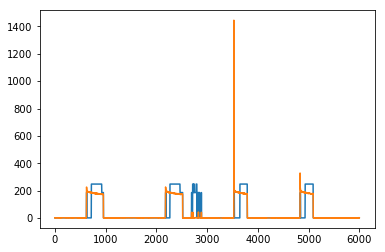

In [250]:
means_ref = ref_model.means_.round().astype(int).flatten().tolist()
predict_ref = np.array([means_ref[int(state)] for state in s_ref])

means_micro = micro_model.means_.round().astype(int).flatten().tolist()
predict_micro = np.array([means_micro[int(state)] for state in s_micro])

plt.plot(predict_ref[:6000])
plt.plot(np.array(refrigerator_test[:6000]))

## Calculate the comparison between aggregation predication and actual for refrigerator

In [251]:
perc_actual = sum(refrigerator_test[:6000])/sum(X_test[:6000])
perc_pred = sum(predict_ref[:6000])/sum(X_test[:6000])

print perc_actual
print perc_pred

[ 0.77949976]
[ 0.7837188]


## Calculate the comparison between aggregation prediction and actual for microwave

[ 0.22050024]
[ 0.16575853]


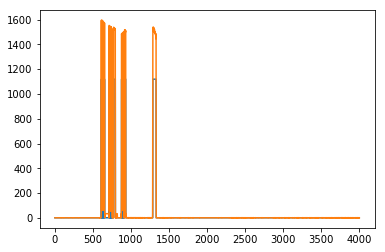

In [277]:
plt.plot(predict_micro[46000:50000])
plt.plot(np.array(microwave_test[46000:50000]))

perc_actual = sum(microwave_test[:6000])/sum(X_test[:6000])
perc_pred = sum(predict_micro[:6000])/sum(X_test[:6000])

print perc_actual
print perc_pred

## Disaggregation for refrigerator

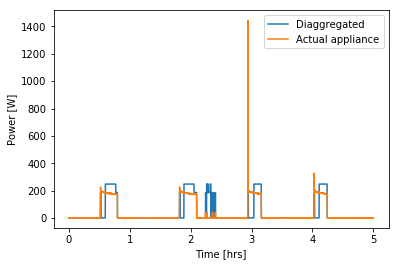

In [272]:
plt.figure()
xaxis = np.linspace(0,5,num=6000)
plt.plot(xaxis,predict_ref[:6000], label = 'Diaggregated')
plt.plot(xaxis,np.array(refrigerator_test[:6000]), label = 'Actual appliance')
plt.ylabel('Power [W]')
plt.xlabel('Time [hrs]')
plt.legend()
plt.savefig('ref_5hrs.png', bbox_inches='tight')

## Disaggregation for microwave

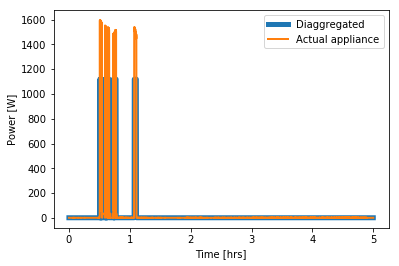

In [276]:
plt.figure()
xaxis = np.linspace(0,5,num=6000)
plt.plot(xaxis,predict_micro[46000:52000], label = 'Diaggregated', linewidth = 5)
plt.plot(xaxis,np.array(microwave_test[46000:52000]), label = 'Actual appliance', linewidth = 2.0)
plt.ylabel('Power [W]')
plt.xlabel('Time [hrs]')
plt.legend()
plt.savefig('micro_5hrs.png', bbox_inches='tight')